In [ ]:
!pip install zarr -q
!pip install plotly -q
!pip install seaborn -q

Starting Data Visualization Process...
✅ Successfully found data directory: /kaggle/input/01-data-preparation/data/ssl4eo-s12/train/S2RGB

Visualizing 3 random samples from the dataset...

Processing Sample 1/3: ssl4eos12_train_seasonal_data_000193.zarr.zip
   -> Extracting & loading image from patch 18, season 1


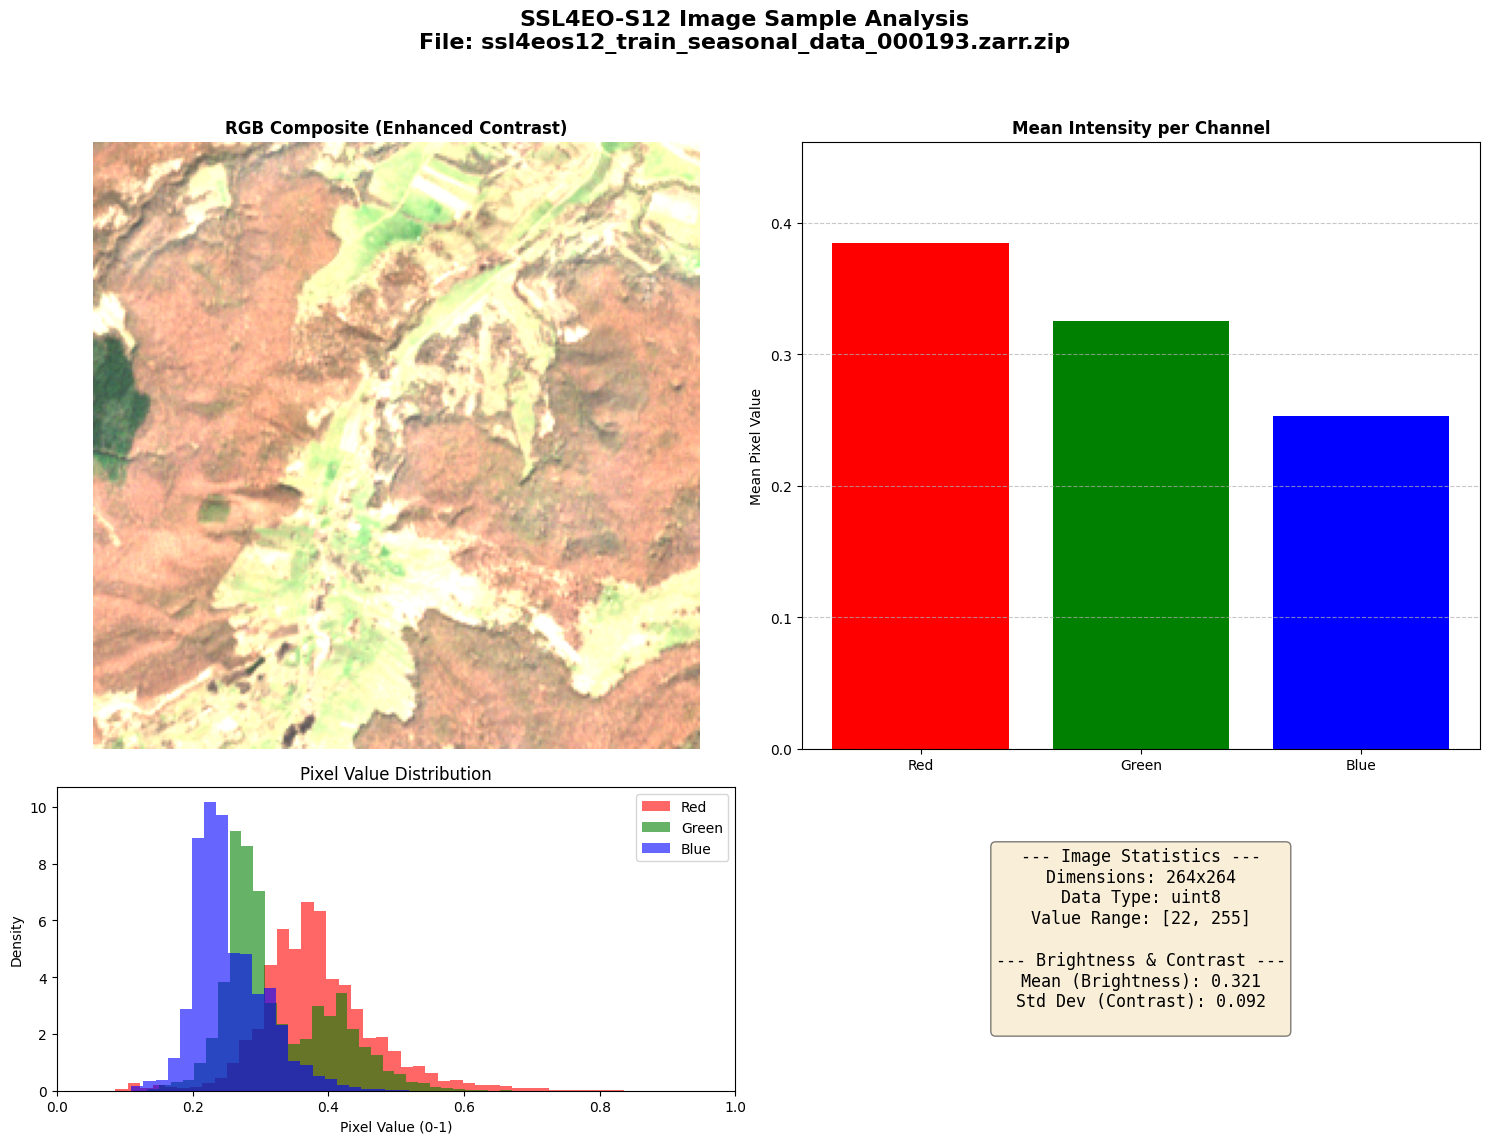


Processing Sample 2/3: ssl4eos12_train_seasonal_data_000020.zarr.zip
   -> Extracting & loading image from patch 25, season 0


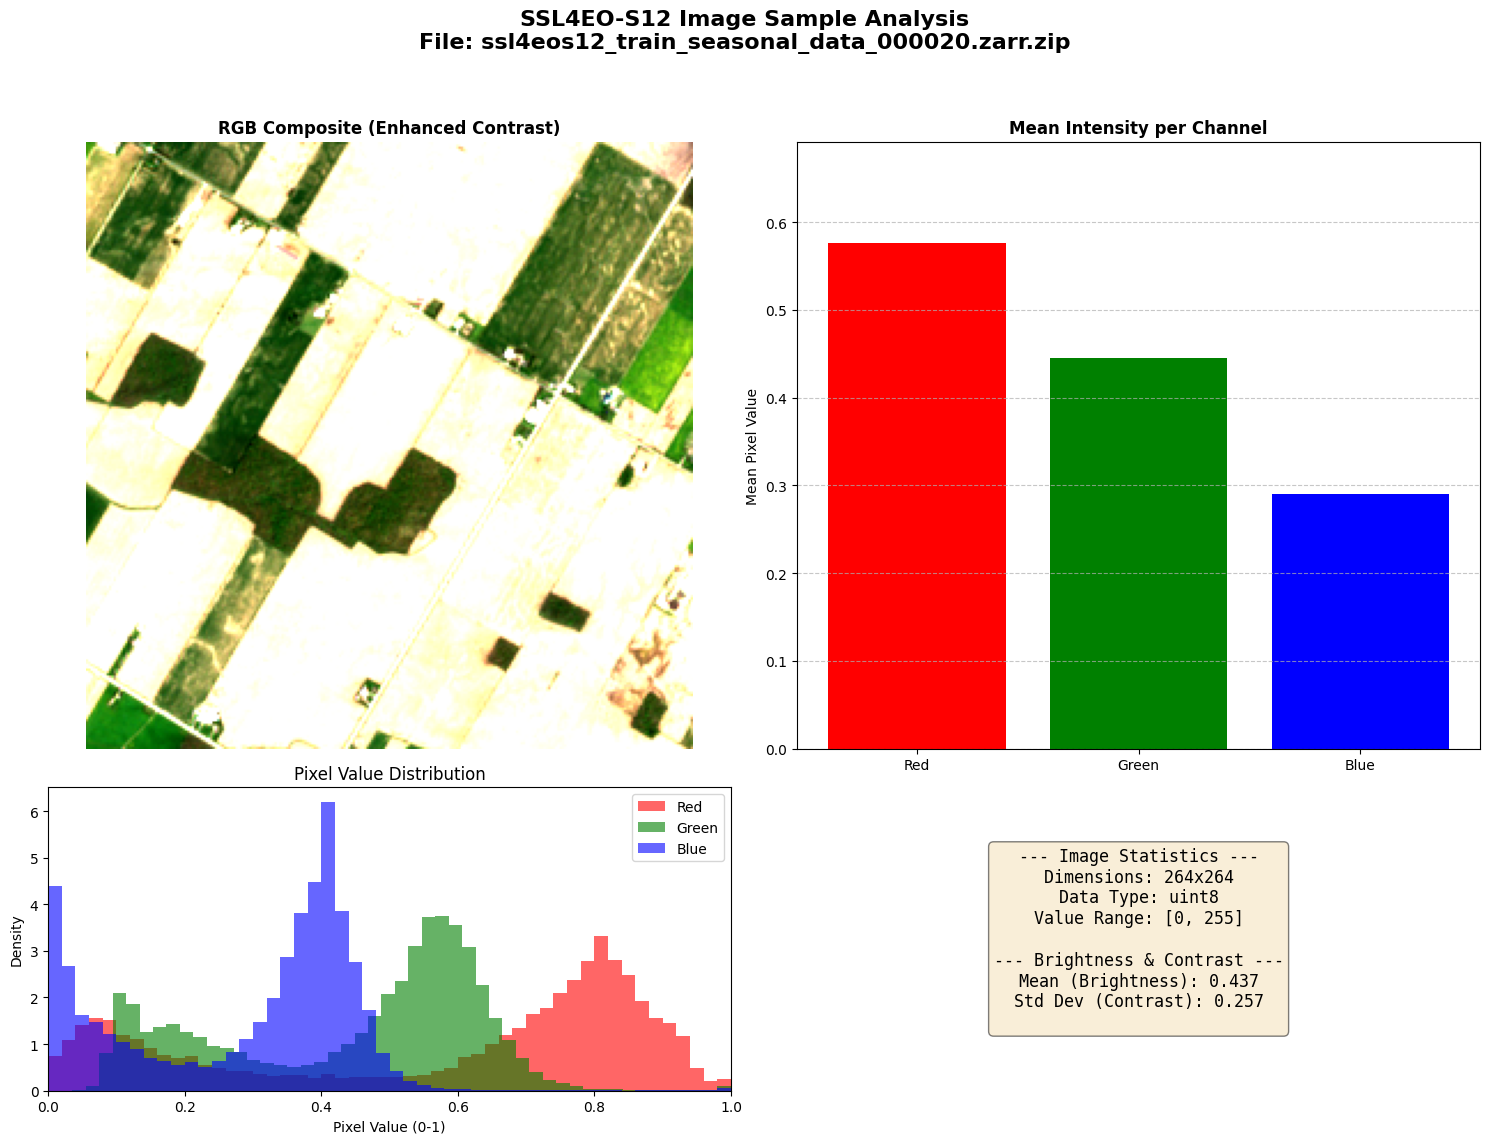


Processing Sample 3/3: ssl4eos12_train_seasonal_data_000282.zarr.zip
   -> Extracting & loading image from patch 0, season 2


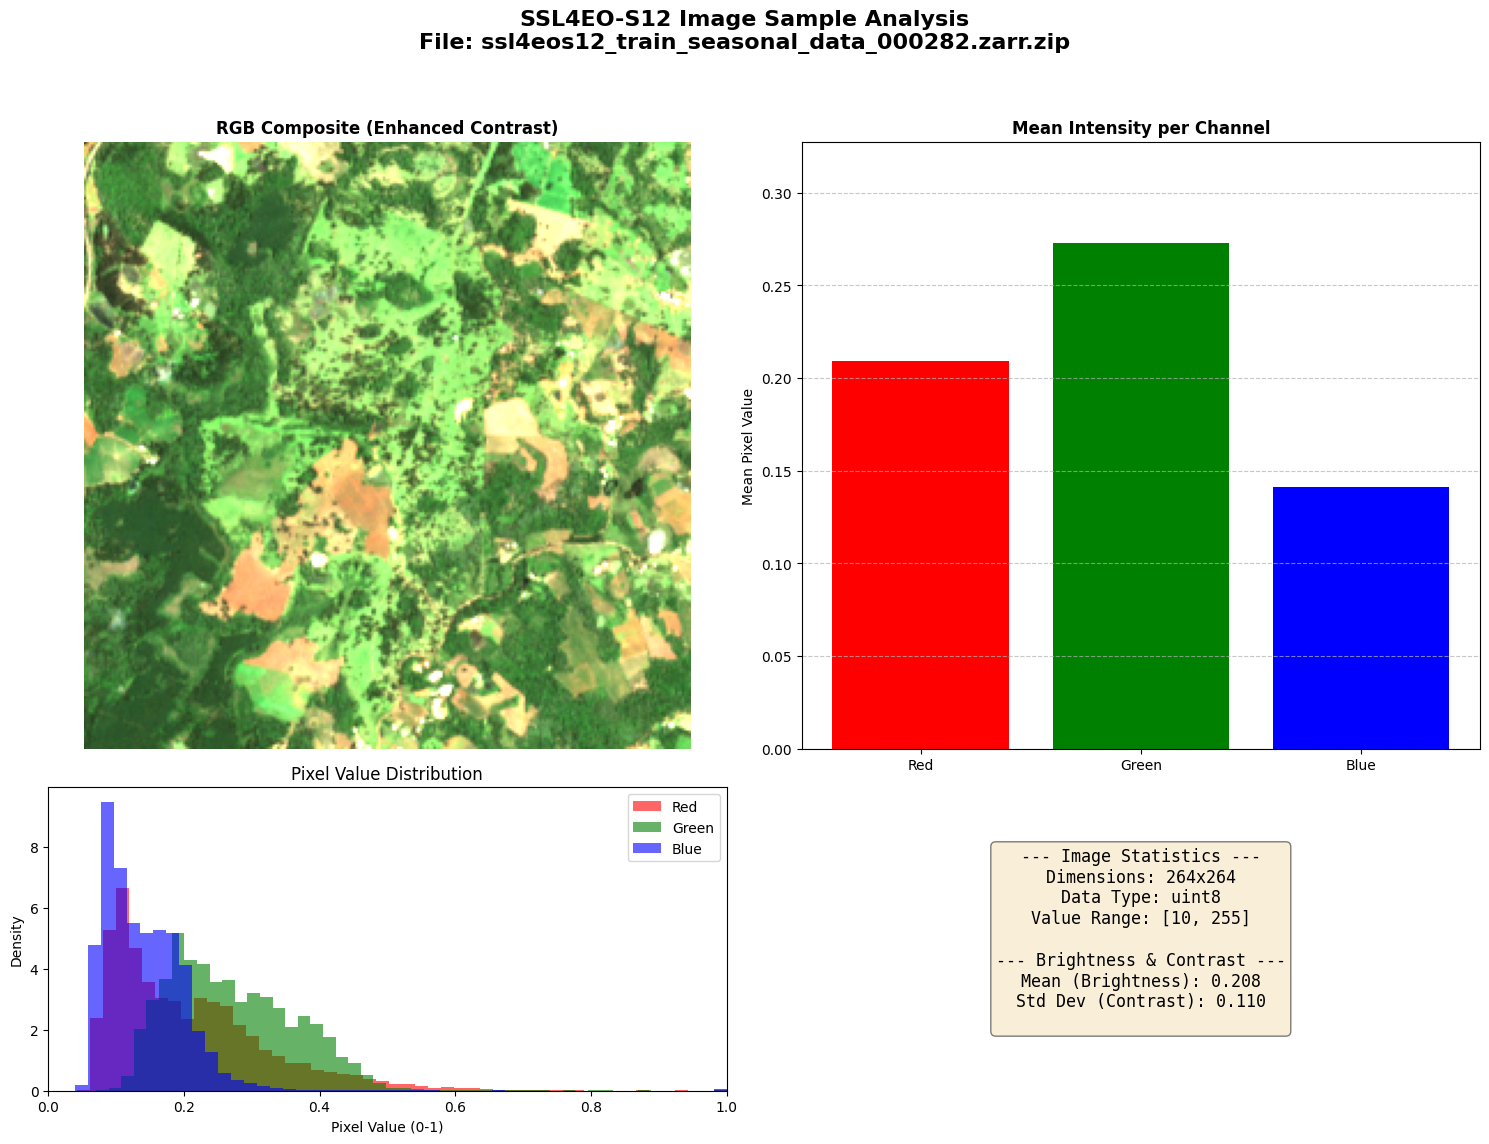


Visualization process finished.


In [3]:
# ==============================================================================
# SSL4EO-S12 DATASET VISUALIZATION NOTEBOOK (v2 - Robust Loading)
# ==============================================================================
# Purpose: To load and visualize sample images from the prepared SSL4EO-S12
#          S2RGB dataset, using a more robust manual extraction method
#          to avoid potential library version issues on Kaggle.
# ==============================================================================

# --- 0. Import Required Libraries ---
!pip install "zarr>=2.10.0" numcodecs -q

import numpy as np
import matplotlib.pyplot as plt
import zarr
from pathlib import Path
import os
import random
import zipfile
import tempfile

# --- 1. Configuration and Setup ---

# Define the path to the dataset added from the '01_data_preparation' notebook.
# The folder name '01-data-preparation' is confirmed from your previous screenshots.
INPUT_NOTEBOOK_FOLDER_NAME = '01-data-preparation'
DATA_DIR = Path(f"/kaggle/input/{INPUT_NOTEBOOK_FOLDER_NAME}/data/ssl4eo-s12/train/S2RGB")


# --- 2. Data Loading Function (Robust Manual Unzip Method) ---

def load_random_image_from_zarr(zarr_file_path):
    """
    Loads a single random image from a specified .zarr.zip file
    by manually unzipping it to a temporary directory first.
    This method avoids using zarr.ZipStore.

    Args:
        zarr_file_path (Path): The full path to the .zarr.zip file.

    Returns:
        numpy.ndarray: A single RGB image as a (3, 264, 264) numpy array with
                       uint8 values, or None if loading fails.
    """
    try:
        # Create a temporary directory to extract the zip file into.
        # The 'with' statement ensures the directory is automatically cleaned up afterwards.
        with tempfile.TemporaryDirectory() as temp_dir:
            
            # 1. Manually unzip the archive into the temporary directory.
            with zipfile.ZipFile(str(zarr_file_path), 'r') as zf:
                zf.extractall(temp_dir)
            
            # 2. Open the now-unzipped Zarr directory.
            zarr_array = zarr.open(temp_dir, mode='r')

            # The 'bands' dataset has a shape like (64, 4, 3, 264, 264).
            num_patches, num_seasons, _, _, _ = zarr_array['bands'].shape
            
            # Select a random patch and a random season.
            random_patch_idx = random.randint(0, num_patches - 1)
            random_season_idx = random.randint(0, num_seasons - 1)
            
            print(f"   -> Extracting & loading image from patch {random_patch_idx}, season {random_season_idx}")
            
            # Directly access the image slice from the Zarr array.
            image_array = zarr_array['bands'][random_patch_idx, random_season_idx, :, :, :]
            
            return image_array

    except Exception as e:
        print(f"Error loading data from {zarr_file_path.name}: {e}")
        return None

# --- 3. Visualization Function ---

def visualize_sample(image_array, filename):
    """
    Creates a professional, multi-panel visualization for a single satellite image.

    Args:
        image_array (numpy.ndarray): The image data in (C, H, W) format, with uint8 values (0-255).
        filename (str): The name of the file the image was loaded from.
    """
    if image_array is None:
        print("Cannot visualize. Image data is not valid.")
        return

    image_float = image_array.astype(np.float32) / 255.0
    
    channels = [
        {'data': image_float[0], 'name': 'Red', 'color': 'red'},
        {'data': image_float[1], 'name': 'Green', 'color': 'green'},
        {'data': image_float[2], 'name': 'Blue', 'color': 'blue'},
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12), gridspec_kw={'height_ratios': [2, 1]})
    fig.suptitle(f'SSL4EO-S12 Image Sample Analysis\nFile: {filename}', fontsize=16, fontweight='bold')
    
    # Panel 1: Main RGB Composite Image
    ax_main = axes[0, 0]
    rgb_display = np.transpose(image_float, (1, 2, 0))
    ax_main.imshow(np.clip(rgb_display * 2.5, 0, 1))
    ax_main.set_title('RGB Composite (Enhanced Contrast)', fontsize=12, fontweight='bold')
    ax_main.axis('off')

    # Panel 2: Mean Intensity per Channel
    ax_channels = axes[0, 1]
    channel_means = [ch['data'].mean() for ch in channels]
    ax_channels.bar([ch['name'] for ch in channels], channel_means, color=[ch['color'] for ch in channels])
    ax_channels.set_title('Mean Intensity per Channel', fontsize=12, fontweight='bold')
    ax_channels.set_ylabel('Mean Pixel Value')
    ax_channels.grid(axis='y', linestyle='--', alpha=0.7)
    ax_channels.set_ylim(0, max(channel_means) * 1.2 if any(channel_means) else 0.1)

    # Panel 3: Pixel Value Distribution
    ax_hist = axes[1, 0]
    for channel in channels:
        ax_hist.hist(channel['data'].flatten(), bins=50, alpha=0.6, label=channel['name'], color=channel['color'], density=True)
    ax_hist.set_title("Pixel Value Distribution", fontsize=12)
    ax_hist.set_xlabel('Pixel Value (0-1)')
    ax_hist.set_ylabel('Density')
    ax_hist.legend()
    ax_hist.set_xlim(0, 1)

    # Panel 4: Text Summary
    ax_text = axes[1, 1]
    ax_text.axis('off')
    summary_text = (
        f"--- Image Statistics ---\n"
        f"Dimensions: {image_array.shape[1]}x{image_array.shape[2]}\n"
        f"Data Type: {image_array.dtype}\n"
        f"Value Range: [{image_array.min()}, {image_array.max()}]\n\n"
        f"--- Brightness & Contrast ---\n"
        f"Mean (Brightness): {image_float.mean():.3f}\n"
        f"Std Dev (Contrast): {image_float.std():.3f}\n"
    )
    ax_text.text(0.5, 0.5, summary_text, transform=ax_text.transAxes, 
                 ha='center', va='center', fontsize=12, family='monospace',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- 4. Main Execution ---

def main():
    """
    Main function to run the visualization process.
    """
    print("Starting Data Visualization Process...")
    if not DATA_DIR.exists():
        print(f"❌ Error: Dataset directory not found at {DATA_DIR}")
        print("Please ensure you have correctly added the output from the data preparation notebook and updated the path.")
        return
    else:
        print(f"✅ Successfully found data directory: {DATA_DIR}")

    zarr_files = sorted(list(DATA_DIR.glob("*.zarr.zip")))
    if not zarr_files:
        print(f"❌ No .zarr.zip files found in {DATA_DIR}")
        return

    num_samples_to_show = 3
    print(f"\nVisualizing {num_samples_to_show} random samples from the dataset...")
    sample_files = random.sample(zarr_files, min(num_samples_to_show, len(zarr_files)))

    for i, file_path in enumerate(sample_files):
        print("\n" + "="*60)
        print(f"Processing Sample {i+1}/{len(sample_files)}: {file_path.name}")
        
        image_data = load_random_image_from_zarr(file_path)
        
        if image_data is not None:
            visualize_sample(image_data, file_path.name)

    print("\n" + "="*60)
    print("Visualization process finished.")

# Run the main function.
if __name__ == '__main__':
    main()

In [5]:
# ==============================================================================
# DATASET AUDIT AND SUMMARY (v2 - Robust Manual Unzip)
# ==============================================================================
# Purpose: To inspect the entire S2RGB dataset to get accurate counts of
#          files and total images, using a robust manual extraction method
#          to avoid library version issues.
# ==============================================================================

import numpy as np
import zarr
from pathlib import Path
import os
from tqdm.notebook import tqdm
import zipfile
import tempfile

# --- Configuration ---
INPUT_NOTEBOOK_FOLDER_NAME = '01-data-preparation' 
DATA_DIR = Path(f"/kaggle/input/{INPUT_NOTEBOOK_FOLDER_NAME}/data/ssl4eo-s12/train/S2RGB")

# --- Analysis Function (Robust Version) ---

def audit_dataset_robust(directory):
    """
    Iterates through all .zarr.zip files using a manual unzip method
    to count total images and check data properties.
    
    Args:
        directory (Path): The path to the directory containing the dataset files.
    """
    print(f"Starting robust audit of directory: {directory}\n")
    
    if not directory.exists():
        print("❌ Error: Directory not found.")
        return

    zarr_files = sorted(list(directory.glob("*.zarr.zip")))
    if not zarr_files:
        print("❌ No .zarr.zip files found.")
        return

    total_files = len(zarr_files)
    total_images = 0
    first_file_checked = False
    
    # Use tqdm for a progress bar
    for file_path in tqdm(zarr_files, desc="Auditing files"):
        try:
            # Create a temporary directory for each zip file
            with tempfile.TemporaryDirectory() as temp_dir:
                # 1. Manually unzip the file
                with zipfile.ZipFile(str(file_path), 'r') as zf:
                    zf.extractall(temp_dir)
                
                # 2. Open the unzipped Zarr directory
                zarr_array = zarr.open(temp_dir, mode='r')

                # Check properties of the 'bands' data on the first file
                if not first_file_checked:
                    bands_array = zarr_array['bands']
                    print("--- First File Properties ---")
                    print(f"File Name: {file_path.name}")
                    print(f"Full 'bands' array shape: {bands_array.shape}")
                    print(f"Data Type (dtype): {bands_array.dtype}")
                    
                    images_in_this_file = bands_array.shape[0] * bands_array.shape[1]
                    print(f"Images per file: {bands_array.shape[0]} (patches) * {bands_array.shape[1]} (seasons) = {images_in_this_file}")
                    
                    single_image_shape = bands_array.shape[2:]
                    print(f"Shape of one individual image instance: {single_image_shape}")
                    print("-----------------------------\n")
                    first_file_checked = True

                # Add the number of images in this file to the total count
                total_images += zarr_array['bands'].shape[0] * zarr_array['bands'].shape[1]

        except Exception as e:
            print(f"Could not process file {file_path.name}: {e}")
            continue

    print("\n--- 📊 DATASET AUDIT SUMMARY ---")
    print(f"Total .zarr.zip files found: {total_files}")
    print(f"Total individual image instances: {total_images:,}")
    
    if first_file_checked:
        conceptual_shape = (total_images,) + single_image_shape
        print(f"Conceptual shape of all individual images stacked: {conceptual_shape}")
    
    print("---------------------------------")


# --- Run the Audit ---
if __name__ == '__main__':
    audit_dataset_robust(DATA_DIR)

Starting robust audit of directory: /kaggle/input/01-data-preparation/data/ssl4eo-s12/train/S2RGB



Auditing files:   0%|          | 0/483 [00:00<?, ?it/s]

--- First File Properties ---
File Name: ssl4eos12_train_seasonal_data_000001.zarr.zip
Full 'bands' array shape: (64, 4, 3, 264, 264)
Data Type (dtype): uint8
Images per file: 64 (patches) * 4 (seasons) = 256
Shape of one individual image instance: (3, 264, 264)
-----------------------------


--- 📊 DATASET AUDIT SUMMARY ---
Total .zarr.zip files found: 483
Total individual image instances: 123,648
Conceptual shape of all individual images stacked: (123648, 3, 264, 264)
---------------------------------
